# 2. Performance analysis at system level

## Database connection
Establish connection to neo4j database with performance data.

In [8]:
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='neo4j')


## Cypher query
Cypher queries are executed to get CPU and memory utilization data. The results are stored in dataframes.

In [9]:
import pandas as pd

cpu_query ="""
MATCH (n:Directory)-[:CONTAINS]->(c:CpuUtilizationRecord { hostname: 'middletier2' })
WHERE n.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN c.timestamp, c.cpuID, c.totalUtilization*100
ORDER BY c.timestamp
"""
df = pd.DataFrame(graph.run(cpu_query).data())
df = df.rename(columns={"c.timestamp": "Timestamp",
                        "c.cpuID": "CPU ID",
                        "c.totalUtilization*100": "CPU Utilization"})
df.drop(df.head(3).index, inplace=True)
df.drop(df.tail(5).index, inplace=True)

mem_query ="""
MATCH (n:Directory)-[:CONTAINS]->(m:MemSwapUsageRecord { hostname: 'middletier2' })
WHERE n.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN m.timestamp, toFloat(m.memUsed)*100 / toFloat(m.memTotal)
ORDER BY m.timestamp
"""
df_mem = pd.DataFrame(graph.run(mem_query).data())
df_mem = df_mem.rename(columns={"m.timestamp": "Timestamp",
                                "toFloat(m.memUsed)*100 / toFloat(m.memTotal)": "Memory Utilization"})
df_mem.drop(df_mem.head(3).index, inplace=True)
df_mem.drop(df_mem.tail(5).index, inplace=True)

## Analysis and Visualization
The data is analyzed, merged and visualized. The timestamps only differ in the microseconds.

They are rounded to the nearest second to allow the merge of the dataframes.

In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].dt.round('1s')
df['CPU ID'] = pd.to_numeric(df['CPU ID'])
df = df.groupby(['Timestamp']).mean()
df = df.drop('CPU ID', 1)

df_mem['Timestamp'] = pd.to_datetime(df_mem['Timestamp'])
df_mem['Timestamp'] = df_mem['Timestamp'].dt.round('1s')
df_mem.set_index('Timestamp', inplace=True)

df = df.merge(df_mem, left_on='Timestamp', right_on='Timestamp')

In [11]:
df.head()

,CPU Utilization,Memory Utilization
Timestamp,,
2015-08-20 06:49:26,0.650651,41.020209
2015-08-20 06:49:36,0.949251,41.007907
2015-08-20 06:49:46,1.002306,41.007490
2015-08-20 06:49:56,7.204219,41.163040
2015-08-20 06:50:06,1.151151,41.151155


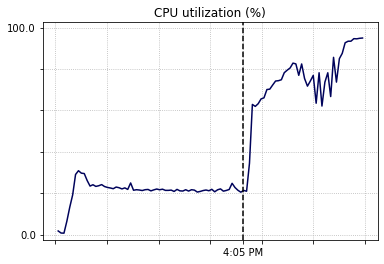

In [12]:
import matplotlib.pyplot as plt

df_cpu_plot = df.rolling(7).mean()
df_cpu_plot = df_cpu_plot.iloc[::7, :]

plt.plot_date(df_cpu_plot.index, df_cpu_plot['CPU Utilization'], fmt='-', color='#00035b')
plt.title('CPU utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
plt.xticks(date_list + ['2015-08-20 08:05'], ['', '', '', '', '', '', '', '4:05 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 08:05', color='black', label='4:05 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# plt.savefig('cpu_plot.pdf')
plt.show()

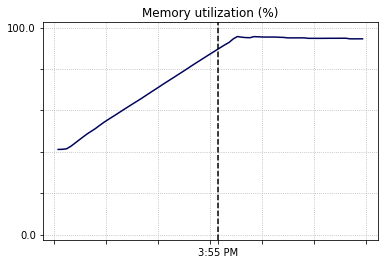

In [13]:
df_mem_plot = df.rolling(10).mean()
df_mem_plot = df_mem_plot.iloc[::10, :]

plt.plot_date(df_mem_plot.index, df_mem_plot['Memory Utilization'], fmt='-', color='#00035b')
plt.title('Memory utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
plt.xticks(date_list + ['2015-08-20 07:55'], ['', '', '', '', '', '', '', '3:55 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 07:55', color='black', label='4:05 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# plt.savefig('mem_plot.pdf')
plt.show()